## Assignment 2 - Nick Keeley - 30 SEP 2021


Note to Grader: I worked together primarily with Geoff Hansen on this assignment. I referenced his code in problem 2 to organize the features/value_counts. For problems 1, 2, and 3, I modified the code shells we were given via Collab, as instructed.


## Problem 1


In [347]:
## Imports and read in data

import pandas as pd
import numpy as np
from scipy import stats

df=pd.read_csv("bank-full.csv")
df
df2= df[["age","balance", "duration", "y"]]

## Observation
observation = [58, 261, 261]

df2
## Things changing across Bayes optimal predictors: QDA/LDA, equal/unequal var-covar matrices, priors, misclassification cost

,age,balance,duration,y
0,58,2143,261,no
1,44,29,151,no
2,33,2,76,no
3,47,1506,92,no
4,33,1,198,no
...,...,...,...,...
45206,51,825,977,yes
45207,71,1729,456,yes
45208,72,5715,1127,yes
45209,57,668,508,no


In [340]:
#### Outline of approach ####

## Multivariate gaussian function (data, data_average, cov-var matrix). Output: pdf of function

## Prior generation.

## Approach = class (data, classification costs, equal var-cov?). Features: means, names, var-cov (if 0).

## Produce likelihoods of classes (data). Output: likelihoods for each class (yes and no).

## Produce posterior probabilities of classes (data, prior).

In [341]:
def multivariate_gaussian_pdf(X, MU, SIGMA):
    """Code from QDA-LDA Iris Example from Data Blog https://xavierbourretsicotte.github.io/MLE_Multivariate_Gaussian.html
    Maximum Likelihood Estimator: Multivariate Gaussian Distribution
        by Xavier Bourret Sicotte, Fri 22 June 2018
    Returns the pdf of a multivariate Gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix"""
    # Initialize and reshape
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)
    p, _ = SIGMA.shape

    # Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(SIGMA))
    exponent = -(1 / 2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Return result
    return float((1. / denominator) * np.exp(exponent))

In [342]:
class QDA:
    """Creates a class for Quadratic Discriminant Analysis
    Input:
        fname = file name for a csv file, must have one column labeled "class" and the rest numeric data
    Methods:
        compute_probabilities = given an input observation computes the likelihood for each class and the GML class
        compute_probabilities: given an input observation and prior probabilities,
            computes the posterior probabilities for each class and most probable class"""

    def __init__(self, fname, unequal, cost):
        # reads the data and computes the statistics needed for classification

        # read the iris data as a Pandas data frame
        df = fname

        ## Read the costs in
        
        self.mis_cost=cost
        
        # separate the class labels from the rest of the data
        # we are assuming the column name with class labels is 'Class'
        # and all other columns are numeric
        self.data_labels = df.loc[:]['y']
        self.data = np.asarray(df.drop('y', axis=1, inplace=False))
        
        # get information about the dimensions the data
        self.num_rows, self.num_cols = self.data.shape
        
        # get the class names as an array of strings
        self.class_names = np.unique(self.data_labels)
        
        # determine number of observations in each class
        self.num_obs = dict()
        for name in self.class_names:
            self.num_obs[name] = sum(self.data_labels == name)
            
        # compute the mean of each class
        self.means = dict()
        for name in self.class_names:
            self.means[name] = np.mean(self.data[self.data_labels == name, :], 0)
        
        # compute the covariance matrix of each class
        if(unequal):
            self.covs = dict()
            for name in self.class_names:
                self.covs[name] = np.cov(np.transpose(self.data[self.data_labels == name, :]))
        else:
            # compute the mean covariance matrix
            self.covs = np.zeros([self.num_cols, self.num_cols])
            for name in self.class_names:
                self.covs = self.covs + self.num_obs[name] * np.cov(np.transpose(self.data[self.data_labels == name, :]))
            self.covs = self.covs / self.num_rows
            
        self.unequal = unequal
            
    def compute_likelihoods(self, x):
        # compute and output the likelihood of each class and the maximum likelihood class

        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        for name in self.class_names:
            likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
            idx = idx + 1
        # get the indices for sorting the likelihoods (in descending order)
        indices_sorted = np.argsort(likelihoods)[::-1]

        # print the predicted class and all class likelihoods
        print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('QDA Class Likelihoods:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(likelihoods[indices_sorted[idx]]))

        # return the likelihoods
        return likelihoods
    
    def compute_probabilities(self, x, priors):
        # compute and output the probability of each class and the maximum probability class
        
        #likelihoods = self.compute_likelihoods(x)
        # check that the input data x has the correct number of rows
        if not (len(x) == self.num_cols):
            print('Data vector has wrong number of values.')
            return -1

        # reformat x as a numpy array, incase the user input a list
        x = np.asarray(x)

        # compute the likelihood of each class
        likelihoods = np.zeros(len(self.class_names))
        idx = 0
        if(self.unequal==True):
            for name in self.class_names:
                likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs[name])
                idx = idx + 1
        else:
            for name in self.class_names:
                likelihoods[idx] = multivariate_gaussian_pdf(x, self.means[name], self.covs)
                idx = idx + 1
        
        #Number of classes
        Nclass = len(self.class_names)
        
        
        #posterior probabilties: likelihood * prior / normalize
        postprob = np.zeros(Nclass)
        idx = 0
        normalize = 0
        
        cost=0
        
        for name in self.class_names:
            
            ## Need to apply or not apply cost
            if(name=="yes"):
                cost=self.mis_cost
            else:
                cost=1
            proportion = likelihoods[idx] * priors[name] * cost
            postprob[idx] = proportion
            normalize += proportion
            idx = idx + 1
        postprob = np.round(postprob / normalize,4)
        # get the indices for sorting the posterior probabilities (in descending order)
        indices_sorted = np.argsort(postprob)[::-1]
        
        
        print('QDA Predicted Class: ' + self.class_names[indices_sorted[0]])
        print('QDA Posterior Probabilities:')
        for idx in range(len(indices_sorted)):
            print(self.class_names[indices_sorted[idx]] + ': ' + str(postprob[indices_sorted[idx]]))

        # return the posterior probabilities
        return postprob


In [343]:
uninformative_priors = {
    "no": 1 / 2,
    "yes": 1 / 2
}
#model_qda.compute_probabilities(Iris_setosa_observation, uninformative_priors)
#print(model_qda)



In [344]:
#### Problem 1.A unequal variance (QDA)

## i: equal class priors, equal misclassification costs

cost=1
lit=QDA(df2,True,cost)
lit.compute_probabilities(observation, uninformative_priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.6571
yes: 0.3429


array([0.6571, 0.3429])

In [345]:
## ii: No prior = .9, yes prior = .1. 

priors = {
    "no": 9/10,
    "yes": 1 / 10
}

cost=1
lit=QDA(df2,True,cost)
lit.compute_probabilities(observation, priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.9452
yes: 0.0548


array([0.9452, 0.0548])

In [346]:
## iii: No prior = .9, yes prior = .1. Misclassification cost 15:1.

priors = {
    "no": 9/10,
    "yes": 1 / 10
}

cost=15
lit=QDA(df2,True,cost)
lit.compute_probabilities(observation, priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.5349
yes: 0.4651


array([0.5349, 0.4651])

In [36]:
#### Problem 1.A equal variance (LDA)

## i: equal class priors, equal misclassification costs

cost=1
lit=QDA(df2,False,cost)
lit.compute_probabilities(observation, uninformative_priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.6459
yes: 0.3541


array([0.6459, 0.3541])

In [37]:
## ii: No prior = .9, yes prior = .1. 

priors = {
    "no": 9/10,
    "yes": 1 / 10
}

cost=1
lit=QDA(df2,False,cost)
lit.compute_probabilities(observation, priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.9426
yes: 0.0574


array([0.9426, 0.0574])

In [38]:
## iii: No prior = .9, yes prior = .1. Misclassification cost 15:1.

priors = {
    "no": 9/10,
    "yes": 1 / 10
}

cost=15
lit=QDA(df2,False,cost)
lit.compute_probabilities(observation, priors)

QDA Predicted Class: no
QDA Posterior Probabilities:
no: 0.5225
yes: 0.4775


array([0.5225, 0.4775])

#### Written Response

The differences in class probabilities does not change much between equal and unequal variance-covariance matrices between classes. For each sub-scenario (i.-iii.), the class probabilities simply shift a bit. However, manipulating priors and misclassification costs made a significant difference in the class probabilities. Increasing the "no" class prior drastically increased the posterior class probabilitiy, which makes sense given that the posterior distribution for the "no" class is subsequently conditioned on a realm of possibilities where falling in the "no" distribution is far more likely. Increasing the misclassification cost of "no" assignment, however, rebalanced the posterior class probabilities. This is likely because QDA/LDA analysis is seeking to minimize loss by selecting the class with the lowest expected cost, but the cost of misclassification has increased significantly.

Ultimately, QDA/LDA analysis yielded "no" as the predicted class for our observation across all adjustments, but I would be less confident about the predicted class if misclassification costs were high.

## Problem 2

In [461]:
## Load in the data

df=pd.read_csv("MushroomData.csv")
df=df.dropna(axis=0)
df

## Text variable read - credit for help: Geoff Hanse

file = open("MushroomVariables.txt","r")
features=file.read()
features=features.split(',')
df=df.set_axis(features, axis=1)
df


,edible_class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8410,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BROWN,CLUSTERED,LEAVES
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES


In [462]:
## Make every entry unique in dataset

col_len=len(df.columns)
row_len=len(df)

for i in range(row_len):
    for j in range(col_len):
        df.loc[i][j]=df.columns[j] + "_" + df.loc[i][j]

In [620]:
## Holdout test set

fraction= 1/3
holdout=int(fraction * len(df))
df_test=df.iloc[0:holdout,] # Test data
df=df.iloc[holdout:,] # Training data


## Edible/Poisonous split

df_edible=df[(df["edible_class"]=="edible_class_EDIBLE")]
df_poison=df[(df["edible_class"]=="edible_class_POISONOUS")]

In [621]:
## Edible data counts

result_edible=pd.DataFrame()
for name in df_edible.columns:
    temp=pd.DataFrame(df_edible[name].value_counts())
    temp=temp.rename(columns={name:"count"})
    result_edible=result_edible.append(temp)
result_edible
total_edible=result_edible.iloc[0]
result_edible
result_edible=result_edible.drop("edible_class_EDIBLE", axis=0)
result_edible

## Poisonous data counts

result_poison=pd.DataFrame()
for name in df_poison.columns:
    temp=pd.DataFrame(df_poison[name].value_counts())
    temp=temp.rename(columns={name:"count"})
    result_poison=result_poison.append(temp)
result_poison
total_poison=result_poison.iloc[0]
result_poison
result_poison=result_poison.drop("edible_class_POISONOUS", axis=0)

## Row names
row_poison=np.array(result_poison.index)
row_edible=np.array(result_edible.index)


In [622]:
## Combine two data frames, filling with 0's

combined=result_edible.merge(result_poison, left_on=row_edible, right_on=row_poison, how="left").fillna(0)
combined=combined.rename(columns={"key_0":"Feature", "count_x":"Edible Count", "count_y":"Poisonous Count"})
combined

,Feature,Edible Count,Poisonous Count
0,cap-shape_CONVEX,164,16.0
1,cap-shape_KNOBBED,148,594.0
2,cap-shape_BELL,148,2.0
3,cap-shape_FLAT,68,521.0
4,cap-surface_SMOOTH,360,503.0
...,...,...,...
57,population_SOLITARY,32,0.0
58,habitat_GRASSES,288,0.0
59,habitat_LEAVES,192,367.0
60,habitat_PATHS,40,360.0


In [774]:
#### Naive Bayes pulled from class code

# Informed priors
Nclasses = np.array([total_edible,total_poison])
TotalClasses = sum(Nclasses)
priors = np.array(Nclasses/TotalClasses)

# Probability of features given classification type

ClassSums = combined.sum(0) # number of features in each class category
v = len(combined.index)# number of distinct features in the data
a = 1.5 # smoothing parameter

Pfeature = np.zeros([len(combined.index), len(combined.columns)])

## Create the conditional probabilities of features

for i in range(len(combined.index)):
    for j in range(1,len(combined.columns)):
        Pfeature[i,j] = (combined.iloc[i,j] + a)/(ClassSums[j] + v*a)
        
# Naive Bayes Classification
# Classification of new review

for x in range(len(df_test)):
    NewFeature = df_test.iloc[x,1:]
    # Match words with the words in the corpus

    FeatureIndex = list()
    for i in range(len(NewFeature)):
        for j in range(len(combined.index)):
            #print("Feature: " + NewFeature[i])
            #print("Comparison" + " " + combined.iloc[j,0])
            if NewFeature[i] == combined.iloc[j,0].strip():
                FeatureIndex.append(j)

    # Likelihoods

    likelihoods = np.array(np.ones(len(combined.columns)))
    for j in range(len(combined.columns)):
        for i in FeatureIndex:
            likelihoods[j] = likelihoods[j]*Pfeature[i,j]

    likelihoods=np.delete(likelihoods,0,0)

    len(combined.columns)

    # Posterior Probabilities


    numerator = likelihoods * priors
    postprob = np.round(numerator/numerator.sum(), 4)
    postprob = np.delete(postprob,1,1)
    postprob

    for i in range(1,len(combined.columns)):
        print(combined.columns[i] + ': ' + str(postprob[i-1]))

Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.3175]
Poisonous Count: [0.6825]
Edible Count: [0.317

## Problem 3

In [335]:
## Adapted from Example 12.1 in Theodoridis/Code by DE Brown

#### THIS FUNCTION WORKS

import numpy as np
import matplotlib.pyplot as plt


def BayesReg(input_N, input_eta, input_theta):
    
    # Number and range of training samples
    N = input_N
    x_min = 0.000001 ### Adjust so log works
    x_max = 2

    # sigma eta and sigma theta 

    #varset_eta = [0.1, 1.0] ### Adjusted so constant = identity
    #varset_theta = [0.2, 2.0] ### Adjusted so constant = identity

    # Variance for the noise, eta
    variance_eta = input_eta
    std_eta = np.sqrt(variance_eta)

    # Set random or true theta parameters for the ground truth equation
    theta_true = np.array([-1.7, -.1, 3.2, 0.7, -0.8])
    theta_distrbd = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
    l = len(theta_true)

    # Parameters for gaussian prior
    variance_theta = input_theta
    sigma_theta = np.sqrt(variance_theta)
    mu_theta_prior = theta_distrbd ### or mu_theta_prior = theta_true 

    # Number of samples for prediction
    Np = 20

    # Generate training samples
    x = np.linspace(x_min, x_max, N, endpoint=False)

    # Generate random eta
    eta = np.random.normal(0, std_eta, N)

    # Measurement matrix
    phi = np.array([np.ones_like(x), x, np.sqrt(x), np.log(x),np.power(x,3)]).T

    # Generate observations with eta
    y = np.matmul(phi, theta_true) + eta

    # Covariance matrix of Gaussian posterior
    temp = np.power(variance_theta, -1) * np.eye(l) + np.matmul(phi.T, phi) * np.power(variance_eta, -1)
    sigma_theta_pos = np.linalg.inv(temp)

    # Posterior mean
    mu_theta_pos =  mu_theta_prior + np.dot(np.power(variance_eta, -1) * (sigma_theta_pos), np.dot(phi.T, (y - np.dot(phi, mu_theta_prior))))

    # Generate sample for predictions
    x_pred = (x_max - x_min) * np.random.random(Np)

    # Prediction measurement matrix
    phi_pred = np.array([np.ones_like(x_pred), x_pred, np.sqrt(x_pred), np.log(x_pred), np.power(x_pred,3)]).T

    # Predicted mean
    mu_y_pred = np.dot(phi_pred, mu_theta_pos)

    # Predicted variance
    temp = np.power(variance_theta, -1) * np.eye(l) + np.matmul(phi_pred.T, phi_pred) * np.power(variance_eta, -1)
    sigma_theta_pos_pred = np.linalg.inv(temp)
    sigma_y_pred = variance_eta + np.dot(np.dot(phi_pred, sigma_theta_pos_pred), phi_pred.T)

    # Plot ground truth and results

    x_true = np.linspace(x_min, x_max, 5000, endpoint=False) 
    phi_true = np.array([np.ones_like(x_true), x_true, np.power(x_true,2), np.power(x_true,3), np.power(x_true,5)]).T 
    y_true = np.dot(phi_true, theta_true)
    
    values=[x_true, y_true, x_pred, mu_y_pred, sigma_y_pred]
    return values

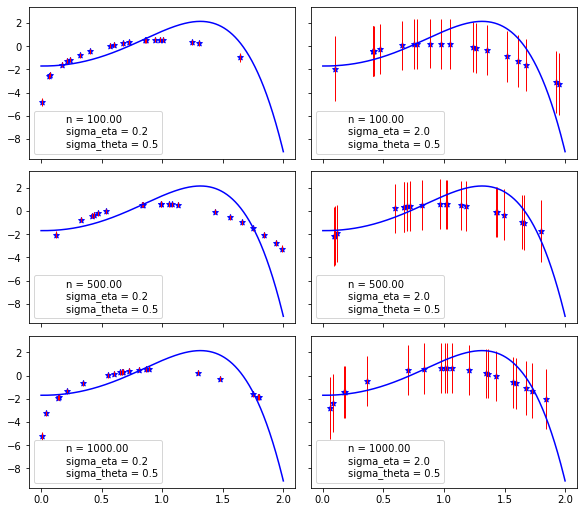

In [336]:
## Inputs

Nset=[100, 500, 1000]
varset_theta=[0.5, 5.0]
varset_eta=[0.2,2.0]

## Create facet grid where sigma_theta == first value

f, ax=plt.subplots(len(Nset),len(varset_eta), sharex=True,sharey=True,figsize=(8,7),constrained_layout=True)

for j in range(len(varset_eta)):
    for i in range(len(Nset)):
        result=BayesReg(Nset[i], varset_eta[j], varset_theta[0]) 
        ax[i,j].plot(result[0],result[1], 'blue')
        ax[i,j].plot(0,0,label="n = {:2.2f}\nsigma_eta = {:2.1f}\nsigma_theta = {:2.1f}".format(Nset[i],varset_eta[j], varset_theta[0]), alpha=0)
        ax[i,j].scatter(result[2], result[3], marker='*', c='blue')
        ax[i,j].errorbar(result[2],result[3], yerr=np.diag(result[4]), linestyle='None', c='red', linewidth=1)
        ax[i,j].legend()
        


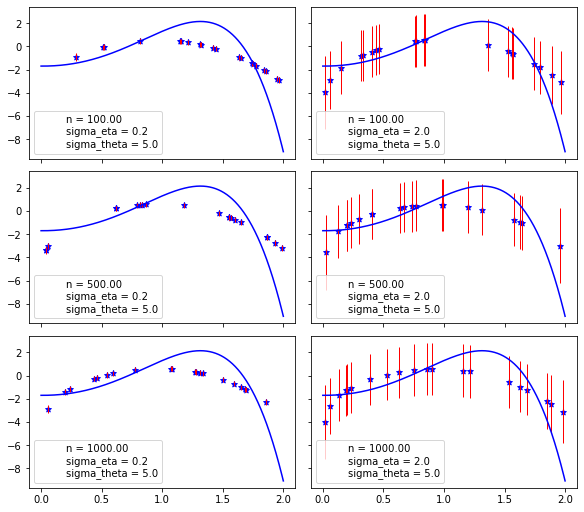

In [337]:
## Create facet grid where sigma_theta == second value

f, ax=plt.subplots(len(Nset),len(varset_eta), sharex=True,sharey=True,figsize=(8,7),constrained_layout=True)

for j in range(len(varset_eta)):
    for i in range(len(Nset)):
        result=BayesReg(Nset[i], varset_eta[j], varset_theta[1]) 
        ax[i,j].plot(result[0],result[1], 'blue')
        ax[i,j].plot(0,0,label="n = {:2.2f}\nsigma_eta = {:2.1f}\nsigma_theta = {:2.1f}".format(Nset[i],varset_eta[j], varset_theta[1]), alpha=0)
        ax[i,j].scatter(result[2], result[3], marker='*', c='blue')
        ax[i,j].errorbar(result[2],result[3], yerr=np.diag(result[4]), linestyle='None', c='red', linewidth=1)
        ax[i,j].legend()

#### Written Response

Decreasing sigma_theta seemed to lessen the spread between predicted points. This makes sense since the distribution of estimates of theta will narrow as the variance of theta diminishes. Increasing the sample size improved the accuracy of the sample predictions, which also makes sense. Finally, increasing sigma_eta increased the error bar size of the predictions. Of note, exceedingly small eta variance resulted in multiple inaccurate predictions being assessed with confidence intervals that did not include the true value of the response variable.